In [ ]:
#RUNNNNNNNNN, he bajao el min lr
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
import random
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from keras.constraints import max_norm



In [0]:
# Añade tu ruta hacia la carpeta que tengas el dataset
df = pd.read_csv('./gdrive/My Drive/Colab Notebooks/dataset.csv')

In [0]:
#df = df.drop(columns=['ip_flags_resbit', 'ip_flags_morefrag', 'ip_frag_offset'])
#df = df.drop(columns=['tcp_flags_cong_window_reduced','tcp_flags_explicit_cong_notif'])
#df = df.drop(columns=['time','tcp_flags_urg_pointer','ip_flags_dontfrag'])
#df = df.drop(columns=['tcp_flags_fin','tcp_flags_syn','tcp_hdr_len'])
#df = df.drop(columns=['tcp_flags_ack','tcp_flags_push','tcp_flags_reset'])

In [0]:
df = df.astype(dtype= {"pkt_length":np.uint16, 'ip_len':np.uint16, 'tcp_window_size_value':np.uint16,
                       'stalling_event':np.uint8, 'measure':np.uint8,
                       'capture':np.uint8})

In [0]:
##model5
df = df.drop(columns=['ip_flags_resbit', 'ip_flags_dontfrag', 'ip_flags_morefrag'])
df = df.drop(columns=['ip_frag_offset', 'tcp_flags_cong_window_reduced', 'tcp_flags_explicit_cong_notif'])
df = df.drop(columns=['tcp_flags_urg_pointer', 'time' ])


In [0]:
df.columns

Index(['pkt_length', 'ip_len', 'tcp_hdr_len', 'tcp_flags_ack',
       'tcp_flags_push', 'tcp_flags_reset', 'tcp_flags_syn', 'tcp_flags_fin',
       'tcp_window_size_value', 'stalling_event', 'measure', 'capture'],
      dtype='object')

In [0]:
df2 = df[['pkt_length', 'tcp_window_size_value']].rolling(8).mean() #add  'ip_len', 'tcp_hdr_len'?

In [0]:
#df2 = df[['pkt_length', 'tcp_window_size_value']].rolling(1).mean()

In [0]:

#df2['pkt_length_or'] = df.pkt_length.values
#df2['tcp_window_size_value_or'] = df.tcp_window_size_value.values
#df2['tcp_hdr_len_or'] = df.tcp_hdr_len.values


#df2['tcp_flags_ack_or'] = df.tcp_flags_ack.values
#df2['tcp_flags_push_or'] = df.tcp_flags_push.values
#df2['tcp_flags_reset_or'] = df.tcp_flags_reset.values
#df2['tcp_flags_syn_or'] = df.tcp_flags_syn.values
#df2['tcp_flags_fin_or'] = df.tcp_flags_fin.values
df2['stalling_event'] = df.stalling_event.values
df2['measure'] = df.measure.values
df2['capture'] = df.capture.values

In [0]:
df3 = df2.dropna()

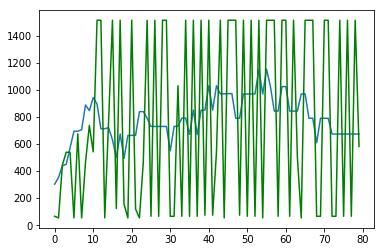

In [0]:
plt.plot(df3.pkt_length.values[20:100])
plt.plot(df.pkt_length.values[20:100], 'g')

In [0]:
df3.head()

,pkt_length,tcp_window_size_value,stalling_event,measure,capture
7,102.000,17236.875,0,0,5
8,162.625,24293.625,0,0,5
9,345.125,32342.750,0,0,5
10,345.125,32374.750,0,0,5
11,462.375,32330.500,0,0,5


In [0]:
np.random.seed(42)
grouped = df3.groupby(['measure','capture']) #######df3
n1 = 1024
n2 = 512
step = 2
split = 0.8
donws_factor = 0.9

X_train = []
X_test = []
y_train = []
y_test = []
for name, group in grouped:
    arr = group.values
    for i in range(0,len(arr)-n1,n1):
        a = arr[i:i+n1]
        option = np.random.rand()
        for j in range(0,len(a)-n2,step):
          b = a[j:j+n2]
          # Case NO stalling event:
          if option <= split:
            if np.all(b[:,-3]==0):
              if np.random.rand() >= donws_factor:
                X_train.extend(b[:,:-3])
                y_train.append(0)
            # Case YES stalling event:
            elif np.all(b[:,-3]==1):
              X_train.extend(b[:,:-3])
              y_train.append(1)
          else:
            if np.all(b[:,-3]==0):
              if np.random.rand() >= donws_factor:
                X_test.extend(b[:,:-3])
                y_test.append(0)
            # Case YES stalling event:
            elif np.all(b[:,-3]==1):
              X_test.extend(b[:,:-3])
              y_test.append(1)


In [0]:
y_train = np.array(y_train)
y_test = np.array(y_test)
y_train = np.reshape(y_train,(-1,1))
y_test = np.reshape(y_test,(-1,1))
print(sum(y_train==0))
print(sum(y_train==1))
print(sum(y_train==2))
print(sum(y_train==3))
print(sum(y_test==0))
print(sum(y_test==1))

[11780]
[12733]
[0]
[0]
[2598]
[2647]


In [0]:
X_train = [item for sublist in X_train for item in sublist]
X_test = [item for sublist in X_test for item in sublist]

In [0]:
X_train = np.reshape(X_train, (-1, n2, len(df3.iloc[0])-3)) ###########df3
X_test = np.reshape(X_test, (-1, n2, len(df3.iloc[0])-3))

In [0]:
norm = X_train.max(axis=0)[0]
X_train = X_train / norm
X_test = X_test / norm

In [0]:
X_test.shape

(5245, 512, 2)

In [0]:
y_test.shape

(5245, 1)

In [0]:
X_train.shape

(24513, 512, 2)

In [0]:
y_train.shape

(24513, 1)

In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dense, Dropout, Embedding
from keras import backend as K
from keras.layers import LSTM, Dense, Bidirectional, Input,Dropout,BatchNormalization, CuDNNGRU, CuDNNLSTM
from keras.layers import Flatten, TimeDistributed, Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.regularizers import l1_l2, l1, l2
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
from keras.constraints import unit_norm
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model


In [0]:
!pip install tensorboardcolab # Solo si no está instalado

In [0]:
len(X_train[0,:])

512

In [0]:
splits = 8 #era 16
n_steps, n_length = n2//splits, splits
n_features = X_train.shape[2]
X_train2 = X_train.reshape((X_train.shape[0], n_steps, n_length, n_features))
X_test2 = X_test.reshape((X_test.shape[0], n_steps, n_length, n_features))

In [0]:
# define model
reg = 0.0001 
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=100, kernel_size=3, activation='relu', 
                                 kernel_regularizer=l2(reg), bias_regularizer=l2(reg)), 
                          input_shape=(None,n_length,n_features)))
model.add(TimeDistributed(Conv1D(filters=100, kernel_size=3, activation='relu', 
                                 kernel_regularizer=l2(reg), bias_regularizer=l2(reg))))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(Dropout(0.5))
model.add(CuDNNLSTM(100, kernel_regularizer=l2(reg), recurrent_regularizer=l2(reg), bias_regularizer=l2(reg))) 
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(100, activation='relu', kernel_constraint=unit_norm(), kernel_regularizer=l2(reg), bias_regularizer=l2(reg)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


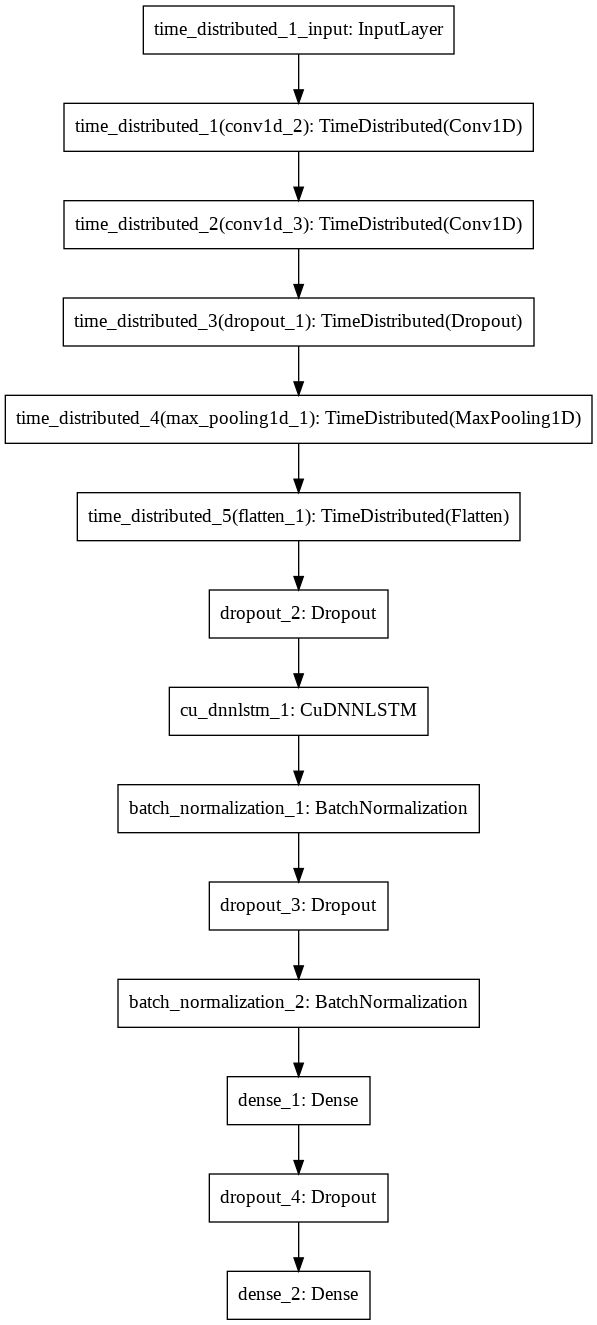

In [0]:
plot_model(model, show_layer_names=True)

In [0]:
# Ruta a donde guardar los pesos de la red que mejor se adapte al dataset de test
filepath="./gdrive/My Drive/Colab Notebooks/Pruebas/weights.best2.hdf5"

# Con la sig. linea indicamos que para guardar el mejor modelo miramos la precisión de el dataset de test (val)
# y que lo que estamos haciendo es maximizar
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# Este callback nos permite parar el entrenamiento cuando no se mejora la precisión en el dataset de test
# Con el parámetro patience indicamos durante cuánto tiempo estamos buscando una mejor precisión
es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=80)

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.9, patience=2, min_lr=0.00001, verbose=1) #0.86 min_lr 2 0 menos 0.0001 #con 0.9; 0.00001 y batch 64 no va mal

# Esto es tensorboard, con el link que te genera puedes 'ver' cómo se va comportando la red
# Irás viendo que la precisión en el train va aumentando pero en el de test puede bajar (overffiting).
# https://py2py.com/cnn-part-4-how-to-use-tensorboard-to-avoid-overfitting/
tbc=TensorBoardColab()

Wait for 8 seconds...


KeyboardInterrupt: ignored

In [0]:
hist = model.fit(X_train2, y_train, epochs=1000, batch_size=64, #con conv1 X_train2, X_test2
                 validation_data=(X_test2, y_test), verbose=1,
                 callbacks=[es, TensorBoardColabCallback(tbc), checkpoint, reduce_lr])

In [0]:
# Para guardar la red completa, carga los pesos de donde estaban guardados, y luego
# los guardamos, pero esta vez con la red al completo.
model.load_weights("./gdrive/My Drive/Colab Notebooks/Pruebas/weights.best2.hdf5")
#model.save("./gdrive/My Drive/Colab Notebooks/Pruebas/model_mean_086f1_3_SMOOTH.h5")
#model.summary()

In [0]:
# Una vez que hemos cargado la red con los mejores parámetros, obtenemos los resultados.
y_pred = model.predict(X_test2)

In [0]:
target_names = ['NoEvent', 'Event', 'Started', 'Ended']
target_names = ['NoEvent', 'Event']
print(classification_report(y_test, np.rint(y_pred), target_names=target_names))

In [0]:
confusion_matrix(y_test, np.rint(y_pred))

In [0]:
stop

In [0]:
from keras.models import load_model
model2 = load_model("./gdrive/My Drive/Colab Notebooks/Pruebas/model_mean_085f1.h5")

In [0]:
model2.summary()
model2.get_config()

In [0]:
hist2 = model2.fit(X_train2, y_train, epochs=1000, batch_size=64,
                 validation_data=(X_test2, y_test), verbose=1,
                 callbacks=[es, TensorBoardColabCallback(tbc), checkpoint])

In [0]:
stop

In [0]:
# define model(model5)
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=16, kernel_size=3, activation='relu',
                             	kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001),
                             	input_shape=(None,n_length,n_features))))
model.add(TimeDistributed(Conv1D(filters=8, kernel_size=5, activation='relu',
                             	kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001))))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(CuDNNLSTM(10, kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001),
                	recurrent_regularizer=l2(0.0001), activity_regularizer=l2(0.0001),
               	return_sequences = False))
#model.add(CuDNNLSTM(50, kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001),
#                	recurrent_regularizer=l2(0.001), activity_regularizer=l2(0.001)))
#model.add(Dropout(0.5))
model.add(Dense(10, activation='relu',kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])


In [0]:
# define model 6
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=20, kernel_size=3, activation='relu',
                             	kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001),
                             	input_shape=(None,n_length,n_features))))
model.add(TimeDistributed(Conv1D(filters=8, kernel_size=5, activation='relu',
                             	kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001))))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(CuDNNLSTM(8, kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001),
                	recurrent_regularizer=l2(0.0001), activity_regularizer=l2(0.0001),
               	return_sequences = False))
#model.add(CuDNNLSTM(50, kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001),
#                	recurrent_regularizer=l2(0.001), activity_regularizer=l2(0.001)))
#model.add(Dropout(0.5))
model.add(Dense(8, activation='relu',kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])


In [0]:
#MODEL JASON
#model = Sequential()
#model.add(TimeDistributed(Conv1D(filters=16, kernel_size=3, activation='relu'),  input_shape=(None,n_length,n_features)))
#model.add(TimeDistributed(Conv1D(filters=16, kernel_size=3, activation='relu')))
#model.add(TimeDistributed(Dropout(0.5)))
#model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
#model.add(TimeDistributed(Flatten()))
#model.add(Dropout(0.5))
#model.add(CuDNNLSTM(50, return_sequences=False))
#model.add(Dropout(0.5))
#model.add(Dense(50, activation='relu'))
#model.add(Dropout(0.5))
reg= 0.0001 #mas ceros es más flexible, si hay overfitting lo hago proximo a 1. Si no aprende, lo hago proximo a 0

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=l2(reg), bias_regularizer=l2(reg)), input_shape=(None,n_length,n_features)))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu',kernel_regularizer=l2(reg), bias_regularizer=l2(reg))))
model.add(BatchNormalization())
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(CuDNNLSTM(100, kernel_constraint=max_norm(3), recurrent_constraint=max_norm(3), bias_constraint=max_norm(3), kernel_regularizer=l2(reg), recurrent_regularizer=l2(reg), bias_regularizer=l2(reg)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(100, kernel_regularizer=l2(reg), bias_regularizer=l2(reg), activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])